In [1]:

import pickle
import networkx as nx
from node2vec import Node2Vec
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import math
from networkx import to_numpy_matrix

In [2]:
EMBEDDING_FILENAME = './embeddings.emb'
EMBEDDING_MODEL_FILENAME = './embeddings.model'

In [3]:
# functions

#display graph
def display_graph(G):
    plt.figure(figsize=(12,12))
    nx.draw(G, node_size=80, node_color='yellow', with_labels=True, nodetype = int)
    return

# node2vec for each node
def create_n2v_dict(G):
    # get node to vec embeddings
    node2vec = Node2Vec(G, dimensions=50, walk_length=5, num_walks=5, workers=4)  
    model = node2vec.fit(window=10, min_count=1, batch_words=4)  
    model.wv.save_word2vec_format(EMBEDDING_FILENAME)
    model.save(EMBEDDING_MODEL_FILENAME)
    emb = pd.read_csv(EMBEDDING_FILENAME, "r")
    
    n2v = dict()
    for i in range(len(emb)):
        tmp = list(emb.iloc[i])[0].split(" ")
        n2v[tmp[0]] = list(map(float, tmp[1:]))
    return n2v

# create implicit feature dictionary
def create_feat_dict(feat):
    feat_dict = dict()
    for i in range(len(feat)):
        tmp = list(feat.loc[i])[0].split(' ')
        tmp = [int(i) for i in tmp]
        #print(tmp)
        feat_dict[str(tmp[0])] = tmp[1:]
    return feat_dict

In [4]:
#Extracting dataframes

feat_names = pd.read_csv("facebook/0.featnames")
edges = pd.read_csv("facebook/0.edges")
feat = pd.read_csv("facebook/0.feat", names = ['vector'])
circles = pd.read_csv("facebook/0.circles")

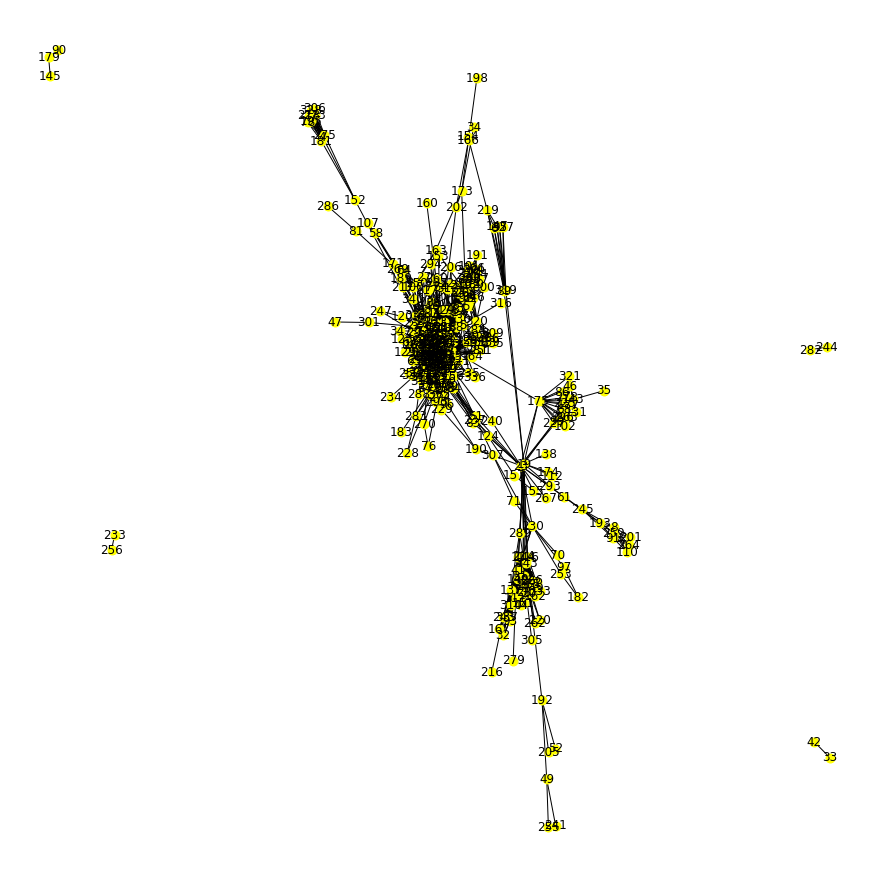

In [5]:
# building the graph

#edgelist is needed for read_edgelist
edge_df = open("facebook/0.edges", "rb")
G = nx.read_edgelist(edge_df)
display_graph(G)
        

In [6]:
#Building edge_dic

# getting nodes and edges for dataframe from graph
print(len(G.nodes))
print(len(G.edges))

node_list = list(np.unique(G.nodes))
edge_list = list(G.edges)


entries = []

# all_edges dictionary
edge_dict = dict()


for node1 in node_list:
    for node2 in node_list:
        if node1 != node2 and (node1, node2) not in edge_dict and (node2, node1) not in edge_dict:
            if (node1, node2) in edge_list:
                edge_dict[(node1, node2)] = 1
            elif (node2, node1) in edge_list:
                edge_dict[(node2, node1)] = 1
            else:
                edge_dict[(node1, node2)] = 0
                
print(len(edge_list))
print(len(edge_dict))                


333
2519
2519
55278


In [7]:
n2v = create_n2v_dict(G)

feat_dict = create_feat_dict(feat)

Computing transition probabilities: 100%|██████████| 333/333 [00:01<00:00, 247.26it/s]


In [8]:
df = pd.DataFrame(columns = ['source_node', 'dest_node', 'edge_exists', 'source_n2v', 'dest_n2v', 'source_feat', 'dest_feat'])      

index = 0
for edge in edge_dict:
    row = [edge[0], edge[1], edge_dict[edge], n2v[edge[0]], n2v[edge[1]], feat_dict[edge[0]], feat_dict[edge[1]]]
    df.loc[index] = row
    index += 1

In [9]:

file = open('df.pickle', 'wb')
pickle.dump(df, file)

#file = open('df.pickle', 'rb')
#df = pickle.load(file)
print(df.head)

<bound method NDFrame.head of       source_node dest_node edge_exists  \
0               1        10           0   
1               1       100           0   
2               1       101           0   
3               1       102           0   
4               1       103           0   
...           ...       ...         ...   
55273          96        98           0   
55274          96        99           0   
55275          97        98           0   
55276          97        99           0   
55277          98        99           0   

                                              source_n2v  \
0      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
1      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
2      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
3      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
4      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
...                                                  ...   
55273  [-0.009693038, 0.004904478

In [10]:
#build train graph

train_graph = nx.Graph()
train_graph.add_nodes_from(node_list)


df_1 = df.loc[df['edge_exists'] == 1]
df_2 = df.loc[df['edge_exists'] == 0].sample(n = len(df_1), random_state = 1)
sample_df = df_1.append(df_2, ignore_index = True) 
print(sample_df.head)

'''train_edge_list = random.sample(edge_list, math.ceil(0.8*len(edge_list)))
train_edge_list = [(i,j) for i,j in train_edge_list]
train_graph.add_edges_from(train_edge_list)
print(len(edge_list), len(train_edge_list))
display_graph(train_graph)
'''

<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            119         1           1   
1            126         1           1   
2            133         1           1   
3            194         1           1   
4            236         1           1   
...          ...       ...         ...   
5033          20        83           0   
5034         190       202           0   
5035          89        94           0   
5036         181       293           0   
5037           1       211           0   

                                             source_n2v  \
0     [-0.005113539, 0.0162464, -0.004656902, -0.000...   
1     [-0.008494396, 0.0031839241, 0.0006186882, 0.0...   
2     [0.0018095083, 0.01504459, -0.01150097, -0.010...   
3     [-0.0034687018, 0.00026966713, -0.00695016, -0...   
4     [-0.01406282, 0.009088622, -0.008409293, -0.01...   
...                                                 ...   
5033  [-0.0021234506, 0.018770823, -0.0072363117, -0

'train_edge_list = random.sample(edge_list, math.ceil(0.8*len(edge_list)))\ntrain_edge_list = [(i,j) for i,j in train_edge_list]\ntrain_graph.add_edges_from(train_edge_list)\nprint(len(edge_list), len(train_edge_list))\ndisplay_graph(train_graph)\n'

In [11]:
# Buildind dataframe for train graph
#print(node_list)
#sample_df['source_feat'] = 0
#sample_df['dest_feat'] = 0
print(sample_df.head)



<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            119         1           1   
1            126         1           1   
2            133         1           1   
3            194         1           1   
4            236         1           1   
...          ...       ...         ...   
5033          20        83           0   
5034         190       202           0   
5035          89        94           0   
5036         181       293           0   
5037           1       211           0   

                                             source_n2v  \
0     [-0.005113539, 0.0162464, -0.004656902, -0.000...   
1     [-0.008494396, 0.0031839241, 0.0006186882, 0.0...   
2     [0.0018095083, 0.01504459, -0.01150097, -0.010...   
3     [-0.0034687018, 0.00026966713, -0.00695016, -0...   
4     [-0.01406282, 0.009088622, -0.008409293, -0.01...   
...                                                 ...   
5033  [-0.0021234506, 0.018770823, -0.0072363117, -0